We want to be able to find abundance values for each KO or ORF across samples. 

some helper functions below

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functions import get_filepath, find_clustered_orfs, find_orfs, find_orfs_from_cluster, find_cluster_from_orf
from functions import samples_from_soils, perturbed_pHs, native_pH, enriched_native_pH

DATDIR = '/projects/p32818/metagenomic_data/data'

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']


In [101]:
import os

os.chdir('/gpfs/projects/p32818/metagenomic_data')

os.getcwd()

import importlib
import functions
importlib.reload(functions)

<module 'functions' from '/gpfs/projects/p32818/metagenomic_data/functions.py'>

## Construct ORF Abundance vs Native pH plot 

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K00370')
ORF_list = list(ORFs)
samples = pd.read_csv(f'{DATDIR}/T0_sampleIDs.tsv', header=None)[0]
sample_list = list(samples)
metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
metadata = metadata.set_index('sample')


chunk_size = 100000

data = np.zeros((len(ORFs), 20)) #data for plot stored here, each row is a dinstinct ORF, 

for chunk in pd.read_csv(get_filepath('T0', 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        orf = filtered_chunk.iloc[i, 1]
        rel_abundance = filtered_chunk.iloc[i, 2]
        spikein = metadata.loc[sample_id, 'spikein_sum']
        row_idx = ORF_list.index(orf)
        col_idx = sample_list.index(sample_id)
        data[row_idx, col_idx] += rel_abundance/spikein
        
        
absolute_data = data

In [ ]:

np.savetxt("out/absolute_data_nar.tsv", np.array(data), delimiter = '\t', fmt = '%.6f')

/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


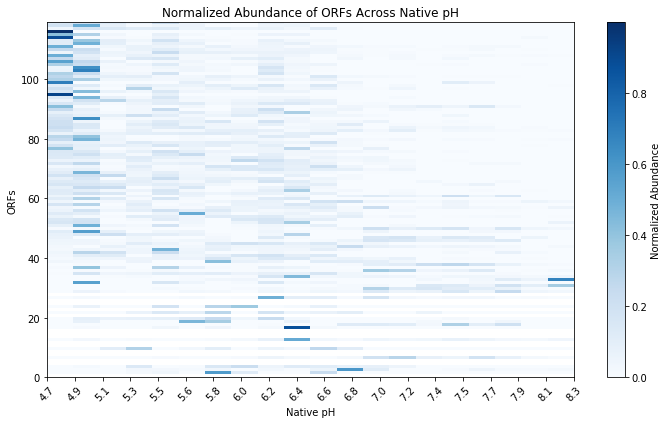

In [7]:
data = pd.read_csv("out/absolute_data_nar.tsv", sep='\t', header=None)
data = data.values
sorted_data = data[np.argsort(-np.abs(data[:, 0]))]
normalized_data = sorted_data / sorted_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('ORFs')
plt.title('Normalized Abundance of ORFs Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

## Construct Cluster ID Abundance vs Native pH plot 

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K00370')
ORF_list = list(ORFs)
print('\n ORFs \n')
print(ORF_list)
Cluster_IDs = ORF_list
for i in range(len(ORF_list)):
    Cluster_IDs[i] = find_cluster_from_orf(ORF_list[i])
    print(Cluster_IDs[i])
print('\n Clusters \n')
print(Cluster_IDs)
    

In [ ]:
IDs = np.array(Cluster_IDs)

sort_indices = np.argsort(-np.abs(data[:, 0])) 

sorted_data = data[sort_indices]
sorted_IDs = IDs[sort_indices]



In [ ]:

import numpy as np


# Dictionary to accumulate data
id_to_data = {} #given an id, the dictionary spits out the data array
for id, row in zip(sorted_IDs, sorted_data):
    if id in id_to_data:
        id_to_data[id] += row
    else:
        id_to_data[id] = row.copy()

# Reconstruct the arrays
unique_IDs = list(id_to_data.keys())
combined_data = np.array([id_to_data[id] for id in unique_IDs])

np.savetxt("out/cluster_ids.tsv", unique_IDs, delimiter = '\t', fmt = '%s')
np.savetxt("out/clustered_data_nar.tsv", combined_data, delimiter = '\t', fmt = '%0.6f')



In [ ]:
cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values
print(cluster_IDs)
print(clustered_data)

normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True) #normalization step

['T0.scaffold_610518454_c1_1', 'T0.scaffold_974243036_c1_1', 'T0.scaffold_51752605_c1_1', 'Soil14.scaffold_596019752_c1_119', 'T0.scaffold_519767388_c1_1', 'T0.scaffold_327279428_c1_4', 'T0.scaffold_273218771_c1_2', 'T0.scaffold_677904738_c1_1', 'T0.scaffold_967757664_c1_1', 'Soil5.scaffold_114379860_c1_1', 'Soil6.scaffold_604673340_c1_1', 'T0.scaffold_409096425_c1_1', 'T0.scaffold_82084267_c1_1', 'T0.scaffold_50999882_c1_2', 'T0.scaffold_61404940_c1_1', 'Soil3.scaffold_63658123_c1_64', 'Soil11.scaffold_594580914_c1_1', 'T0.scaffold_1146579158_c1_1', 'T0.scaffold_1087053736_c1_1', 'Soil3.scaffold_253488375_c1_4', 'Soil5.scaffold_416434691_c1_48', 'Soil6.scaffold_509384248_c1_7', 'T0.scaffold_287104333_c1_1', 'Soil14.scaffold_1008884942_c1_1', 'Soil9.scaffold_766455321_c1_2', 'Soil3.scaffold_31685847_c1_1', 'Soil5.scaffold_376523767_c1_1', 'Soil11.scaffold_437898375_c1_1', 'Soil5.scaffold_352638952_c1_1', 'Soil5.scaffold_342438982_c1_1', 'Soil6.scaffold_274716451_c1_1', 'Soil17.scaffold

/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


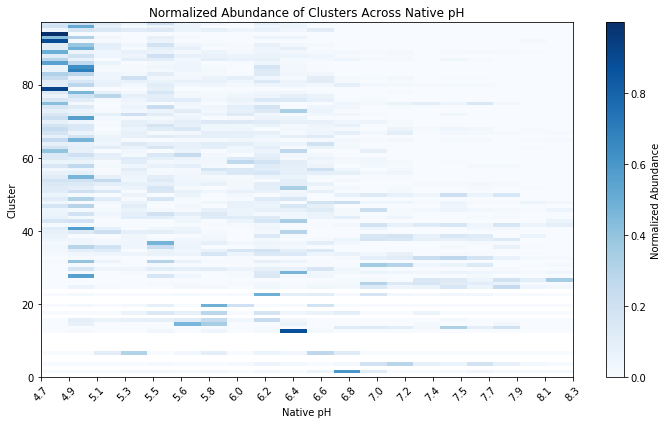

In [9]:

x = np.linspace(4.7, 8.3, 20)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Cluster')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#checking cluster organization
cluster_IDs = pd.read_csv('out/cluster_ids.tsv')
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
cluster = cluster_IDs[4] #pick a cluster
ORFS = find_orfs_from_cluster(cluster)
abundance = np.zeros(20)
samples = pd.read_csv(f'{DATDIR}/T0_sampleIDs.tsv', header=None)[0]
sample_list = list(samples)

metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata = metadata.set_index('sample')

chunk_size = 100000



#find its abundance array at T0
for chunk in pd.read_csv(get_filepath('T0', 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFS)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        rel_abundance = filtered_chunk.iloc[i, 2]
        spikein = metadata.loc[sample_id, 'spikein_sum']
        idx = sample_list.index(sample_id)
        abundance[idx] += rel_abundance/spikein

print(abundance)

#cluster_IDs[3]: [0.20815558 0.15617367 0.01602243 0.00122829 0.03919204 0.011085250.00101163 0.0021338  0.02714269 0.02790571 0.         0.0.         0.00163234 0.         0.         0.         0.0.         0.        ]
#cluster_IDs[4]:[0.15574425 0.00228994 0.00155774 0.0008598  0.00964727 0.00064664 0.00118024 0.         0.         0.         0.         0. 0.         0.         0.         0.         0.         0. 0.00402874 0.        ]



[0.15574425 0.00228994 0.00155774 0.0008598  0.00964727 0.00064664
 0.00118024 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00402874 0.        ]


Note then: earlier in cluster ID list means enriched in a more acidic environment. labels on fig 1 y axis are backwards. 

## PCA on plot above 

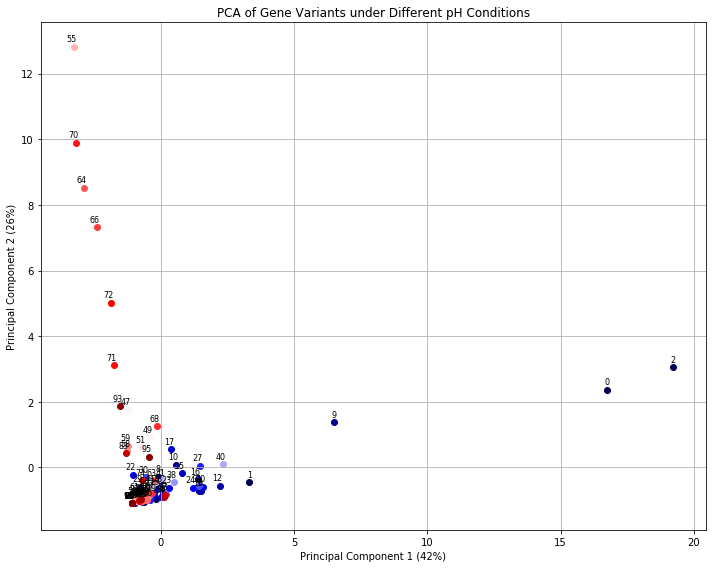

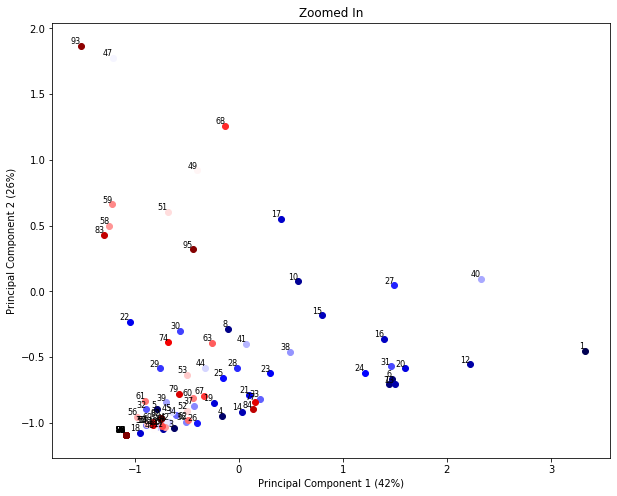

Principal Component 1: 42.17%
Principal Component 2: 26.19%


In [4]:

#try this: 
#nonneagive matrix factorization -- shows more signal when data is positive

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
data = clustered_data.values 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)


# Generate colors based on row index
row_indices = np.arange(principal_components.shape[0])
colors = plt.cm.seismic(row_indices / row_indices.max())

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
    plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')


plt.xlabel('Principal Component 1 (42%)')
plt.ylabel('Principal Component 2 (26%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()

#plot again but zoomed in


plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if principal_components[i, 0] < 5 and principal_components[i, 1] < 2:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
        plt.text(principal_components[i, 0], principal_components[i, 1], str(i), fontsize=8, ha='right', va='bottom')

plt.xlabel('Principal Component 1 (42%)')
plt.ylabel('Principal Component 2 (26%)')
plt.title('Zoomed In')
plt.show()


for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"Principal Component {i}: {ratio * 100:.2f}%")


In [30]:
print(pca.components_[1])
print(len(pca.components_[0]))

[0.02948998 0.0283033  0.0649185  0.06886736 0.06242782 0.05809132
 0.06275206 0.05135363 0.059954   0.03332222 0.06061241 0.10493088
 0.32373814 0.28085996 0.39380928 0.39141815 0.34758995 0.36104626
 0.35368888 0.29645315]
20


## Clustering in Phenotype Space

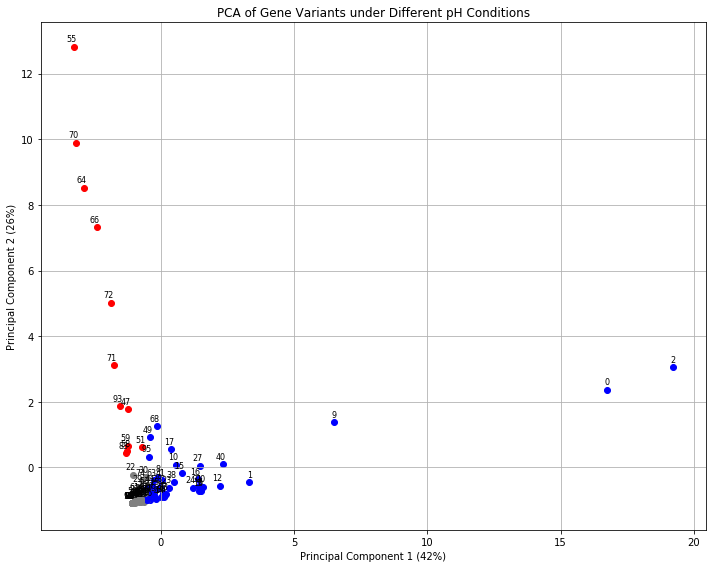

In [17]:

#try this: 
#nonneagive matrix factorization -- shows more signal when data is positive

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
data = clustered_data.values 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

group1 = [] #the group of variants with a positive first compenent
group2 = [] #the group of variants with a negative first component, positive second componenet
group3 = [] #the group of variants with a negative first component, negative second componenet

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if principal_components[i, 0] > -0.5:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='blue')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group1.append(i)
    elif principal_components[i, 1] > 0:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='red')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group2.append(i)
    else:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='grey')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group3.append(i)


plt.xlabel('Principal Component 1 (42%)')
plt.ylabel('Principal Component 2 (26%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
print('group 1', group1)
print('group 2', group2)
print('group 3', group3)

group 1 [0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 31, 33, 37, 38, 40, 41, 44, 49, 52, 53, 60, 62, 63, 67, 68, 77, 84, 95]
group 2 [47, 51, 55, 58, 59, 64, 66, 70, 71, 72, 83, 93]
group 3 [3, 5, 11, 18, 22, 29, 30, 32, 34, 35, 36, 39, 42, 43, 45, 46, 48, 50, 54, 56, 57, 61, 65, 69, 73, 74, 75, 76, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96]


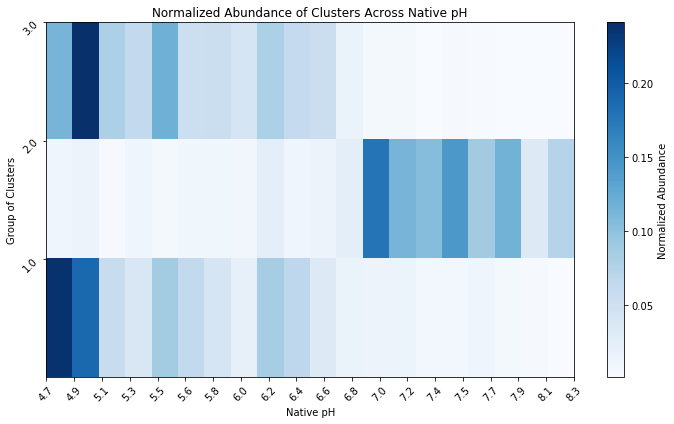

In [20]:
cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values


grouped_data = np.zeros((3, 20))

for i, datum in enumerate(clustered_data):
    if i in group1:
        grouped_data[0] += datum
    elif i in group2: 
        grouped_data[1] += datum
    else:
        grouped_data[2] += datum
        
normalized_data = grouped_data / grouped_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)
y = np.linspace(1,3,3)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Group of Clusters')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(y[0], y[-1], len(y)), labels=[f"{val:.1f}" for val in y], rotation=45)

plt.tight_layout()
plt.show()

Try removing soil 1 and 2 from the PCA

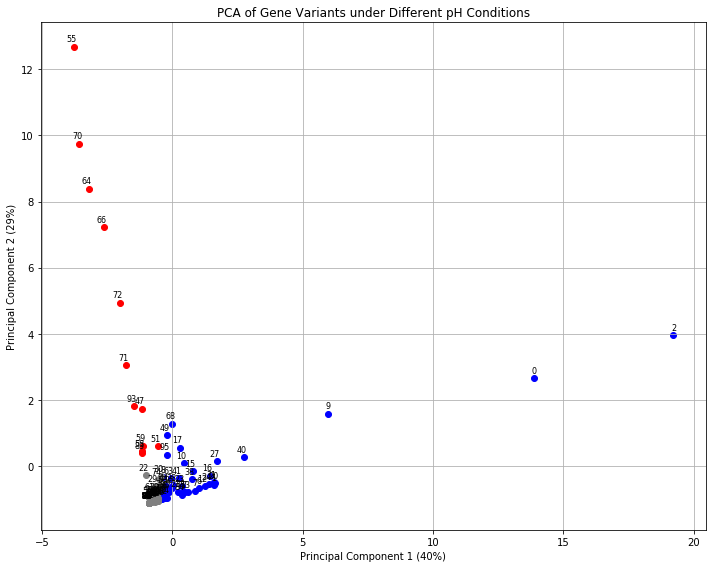

Principal Component 1: 40.71%
Principal Component 2: 29.04%


In [33]:

#try this: 
#nonneagive matrix factorization -- shows more signal when data is positive

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
data = clustered_data.values 

data = data[:,2:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

group1 = [] #the group of variants with a positive first compenent
group2 = [] #the group of variants with a negative first component, positive second componenet
group3 = [] #the group of variants with a negative first component, negative second componenet

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if principal_components[i, 0] > -0.4:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='blue')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group1.append(i)
    elif principal_components[i, 1] > 0:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='red')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group2.append(i)
    else:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='grey')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group3.append(i)


plt.xlabel('Principal Component 1 (40%)')
plt.ylabel('Principal Component 2 (29%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()


for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"Principal Component {i}: {ratio * 100:.2f}%")


In [34]:
print(group1)
print(group2)
print(group3)
print(len(group1))
print(len(group3))

[0, 1, 2, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 27, 28, 31, 33, 36, 37, 38, 40, 41, 44, 49, 52, 53, 60, 62, 63, 67, 68, 77, 79, 84, 95]
[47, 51, 55, 58, 59, 64, 66, 70, 71, 72, 83, 93]
[3, 4, 5, 11, 18, 22, 26, 29, 30, 32, 34, 35, 39, 42, 43, 45, 46, 48, 50, 54, 56, 57, 61, 65, 69, 73, 74, 75, 76, 78, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96]
42
43


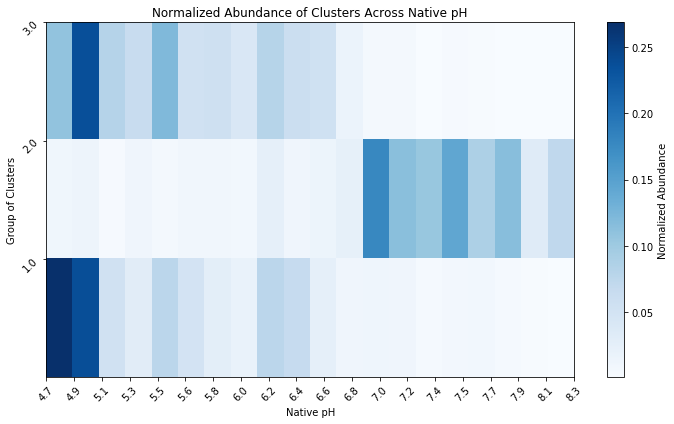

In [35]:
cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values


grouped_data = np.zeros((3, 20))

for i, datum in enumerate(clustered_data):
    if i in group1:
        grouped_data[0] += datum
    elif i in group2: 
        grouped_data[1] += datum
    else:
        grouped_data[2] += datum
        
normalized_data = grouped_data / grouped_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)
y = np.linspace(1,3,3)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Group of Clusters')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(y[0], y[-1], len(y)), labels=[f"{val:.1f}" for val in y], rotation=45)

plt.tight_layout()
plt.show()

Try horizantly appending more data to produce better a better PCA? This doesn't seem to work, but I leave the concatonated matrix below. 

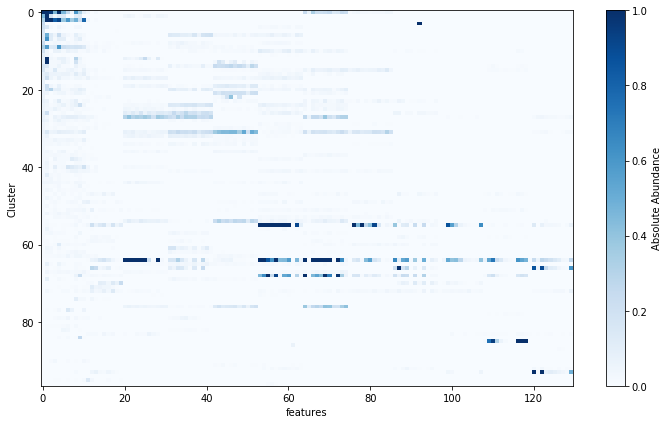

In [ ]:
df = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)

for soil in soils:
    new = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    df = pd.concat([df, new], axis=1)
    
df = df.values 



plt.figure(figsize=(10, 6))

plt.imshow(df, aspect='auto', cmap='Blues', vmin = 0, vmax = 1)

plt.xlabel('features')
plt.ylabel('Cluster')

plt.colorbar(label='Absolute Abundance')


plt.tight_layout()
plt.show()

## Applying the new binning

In [103]:
native = np.zeros(len(soils))
print(soils)
for i, soil in enumerate(soils):
    native[i] = native_pH(soil)
    #print(soil, native[i])
    print(soil, perturbed_pHs(soil))
    
print(native)

print(native_pH('Soil1'))

['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
Soil3 [3.486, 3.9330000000000003, 4.315, 4.712, 4.976, 5.444, 6.381, 6.778, 7.1739999999999995, 7.643, 8.22]
Soil5 [3.775, 4.163, 4.556, 5.156000000000001, 5.733, 6.332999999999999, 6.922000000000001, 7.21, 7.535, 7.811, 8.099]
Soil6 [3.847, 4.25, 4.628, 4.904, 5.492000000000001, 6.093, 6.502000000000001, 6.934, 7.318, 7.931, 8.48]
Soil9 [4.051, 4.373, 4.688, 5.144, 5.6610000000000005, 6.393, 6.862, 7.066, 7.497999999999999, 7.871, 8.53]
Soil11 [4.255, 4.4830000000000005, 4.784, 5.12, 5.21, 5.888999999999999, 6.537999999999999, 6.84, 7.497999999999999, 8.147, 8.58]
Soil12 [4.051, 4.363, 4.724, 4.837, 5.529, 6.0089999999999995, 6.441, 6.91, 7.426, 8.075, 8.243]
Soil14 [3.883, 4.4830000000000005, 4.748, 5.444, 6.1770000000000005, 6.72, 7.222, 7.667000000000001, 7.895, 8.279, 8.63]
Soil15 [4.279, 4.556, 4.772, 5.18, 5.565, 6.129, 6.682, 7.535, 8.033, 8.508, 8.59]
Soil16 [3.907, 4.195, 4.664, 4

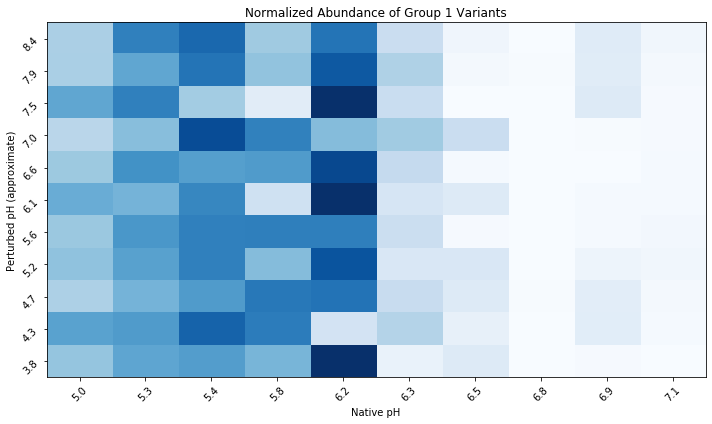

In [134]:
data = np.zeros((10,11))

group = group1

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

data = data.T

plt.figure(figsize=(10, 6))

normalized_data = data / data.sum(axis=1, keepdims=True) #normalization step

plt.imshow(normalized_data, aspect='auto', cmap='Blues', origin='lower', vmax = 0.3)

plt.xlabel('Native pH')
plt.ylabel('Perturbed pH (approximate)')

y = np.linspace(3.8, 8.4, 11)
plt.yticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.xticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)


plt.title(label='Normalized Abundance of Group 1 Variants')


plt.tight_layout()
plt.show()


            

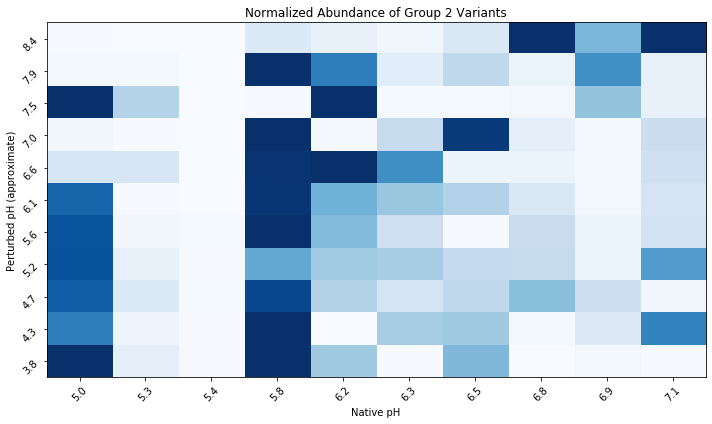

In [137]:
data = np.zeros((10,11))

group = group2

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

data = data.T

plt.figure(figsize=(10, 6))

normalized_data = data / data.sum(axis=1, keepdims=True) #normalization step

plt.imshow(normalized_data, aspect='auto', cmap='Blues', origin='lower', vmax = 0.3)

plt.xlabel('Native pH')
plt.ylabel('Perturbed pH (approximate)')

y = np.linspace(3.8, 8.4, 11)
plt.yticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.xticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)


plt.title(label='Normalized Abundance of Group 2 Variants')


plt.tight_layout()
plt.show()


            

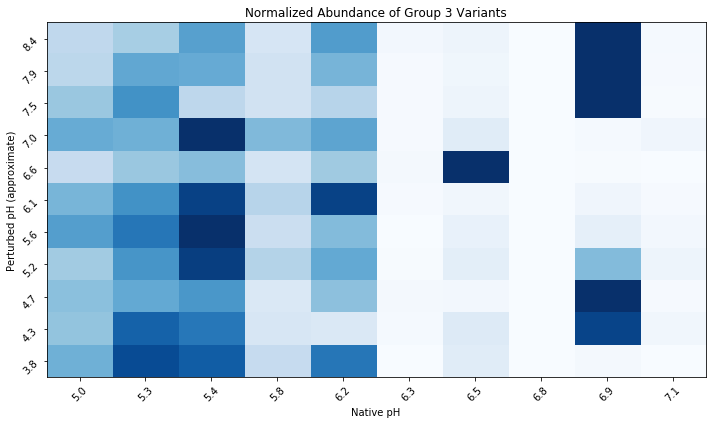

In [136]:
data = np.zeros((10,11))

group = group3

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

data = data.T

plt.figure(figsize=(10, 6))

normalized_data = data / data.sum(axis=1, keepdims=True) #normalization step

plt.imshow(normalized_data, aspect='auto', cmap='Blues', origin='lower', vmax = 0.3)

plt.xlabel('Native pH')
plt.ylabel('Perturbed pH (approximate)')

y = np.linspace(3.8, 8.4, 11)
plt.yticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.xticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)


plt.title(label='Normalized Abundance of Group 3 Variants')


plt.tight_layout()
plt.show()


            

## Construct Cluster ID vs Change in pH plot

The input of this will be a soil. It must be one of the soils that is actually perturbed. 

Then, given that soil sample, you immediately know the native pH and a set of perturbed pHs. We have metagenomic data for 11 (?) perturbed pHs per soil. We also have already collected the data for for T0 sample, which is the corresponding column in the data matrix above. 

First, gather the set of new pHs and new abundances for that sample. 

Note that there may be clusters not present in the T0 samples? But, we only want to consider the ones that are available at T0, so we can consider change.

This is completed in pH_perturbation.py, but some processing is below. 

perturbed soils are 3, 5, 6, 9, 11, 12, 14, 15, 16, 17

In [ ]:
#Soil3, 5, 6, 9, 11, 12, 14, 15, 16, 17
soil = 'Soil17'
print(perturbed_pHs(soil))
print(len(perturbed_pHs(soil)))

print(native_pH(soil))

print(samples_from_soils(soil))

In [ ]:
np.savetxt("out/soil3data.tsv", data, delimiter = '\t', fmt = '%0.6f')

In [ ]:
soil3data = pd.read_csv("out/Soil11data.tsv",sep='\t',header=None)
data = pd.read_csv("out/clustered_data_nar.tsv",sep='\t',header=None)
soil3data = soil3data.values
data = data.values

#extract data from first column for T0, so that we can really talk about change

soil = 'Soil11'

selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
#data = data[:, selected]
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
index = soils.index(soil)
soil3_T0 = data[:, index]


In [ ]:
pHs = np.array(perturbed_pHs(soil))
sorted_indices = np.argsort(pHs)
sorted_pH = pHs[sorted_indices]
sorted_data = soil3data[:, sorted_indices]


In [ ]:
print(sorted_pH)

change_in_pH = sorted_pH.copy()
nativepH = native_pH(soil)

for i in range(len(sorted_pH)):
    change_in_pH[i] = sorted_pH[i] - nativepH

In [ ]:
change_in_abundance = sorted_data - soil3_T0[:,np.newaxis]

In [ ]:
plt.figure(figsize=(10, 6))

x = change_in_pH

plt.imshow(change_in_abundance, aspect='auto', cmap='coolwarm', extent=[x[0], x[-1], 0, change_in_abundance.shape[0]], vmin = -0.3, vmax = 0.3)

plt.xlabel('Change in pH')
plt.ylabel('Cluster')
plt.title(f'Change in Abundance per cluster, Native pH =  {nativepH}')

plt.colorbar(label='Change in Absolute Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

x = sorted_pH

plt.imshow(sorted_data, aspect='auto', cmap='coolwarm', extent=[x[0], x[-1], 0, sorted_data.shape[0]], vmin = 0, vmax = 0.1)

plt.xlabel('Change in pH')
plt.ylabel('Cluster')
plt.title('Change in Abundance per cluster, Native pH = 3.933')

plt.colorbar(label='Change in Absolute Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

## Construct scatter plot where x is peak native pH, y is peak perturbed pH, dots are cluster IDs

Steps:

1. function -- enriched_native_pH defined above now 
    input: cluster ID, filtered data matrix
    output: soil where it is most enriched (out of the 11)



2. function
    input: cluster ID and soil
    output: perturbed pH where it is most enriched, given it started in that soil 


In [ ]:
#first, filter the data 
#we only want rows which are actually perturubed
cluster_IDs = pd.read_csv('metagenomic_data/out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('metagenomic_data/out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values

#soils perturbed: 3, 5, 6, 9, 11, 12, 14, 15, 16, 17
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
data = clustered_data[:, selected]

print(len(data[0]))

print(enriched_native_pH(cluster_IDs[30], data, cluster_IDs))
print(samples_from_soils('Soil14'))



Given a cluster ID, we know the native pH where it is most enriched. Look at all of the perturbations which begin with that native pH, and identify which one of these it is most enriched in. 

In [ ]:
cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values

#soils perturbed: 3, 5, 6, 9, 11, 12, 14, 15, 16, 17
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
filtered_data = clustered_data[:, selected]

data = np.zeros((len(cluster_IDs), 2))  #for each cluster ID, we want to specificfy a native pH and a perturbed pH where it is most enriched


for i, CID in enumerate(cluster_IDs):
    print(i)
    soil = enriched_native_pH(CID, filtered_data, cluster_IDs)
    data[i, 0] = native_pH(soil)
    #ORFs = find_orfs(get_filepath(soil, 'annotation'), 'K00370') #ORFs for the specified protein
    ORFs = find_orfs_from_cluster(CID) #ORFs for the specified cluster

    #Unique_IDs is the array, defined earlier, containing the list of cluster IDs

    sample_list = samples_from_soils(soil)

    metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
    metadata = metadata.set_index('sample')

    chunk_size = 100000

    abundance = np.zeros(11) #for a given CID the specified soil, there are 11 perturbed samples

    for chunk in pd.read_csv(get_filepath(soil, 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
        filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
        for i in range(len(filtered_chunk)):
            sample_id = filtered_chunk.iloc[i, 0]
            if sample_id in sample_list:
                orf = filtered_chunk.iloc[i, 1]
                rel_abundance = filtered_chunk.iloc[i, 2]
                spikein = metadata.loc[sample_id, 'spikein_sum']
                idx = sample_list.index(sample_id)
                abundance[idx] += rel_abundance/spikein
                
    
    pHs = perturbed_pHs(soil)
    data[i, 1] = pHs[np.argmax(abundance)]

print(data)

In [ ]:
pHs = perturbed_pHs(soil)
print(np.argmax(abundance))
print(native_pH(soil))
print(pHs[np.argmax(abundance)])

Now, perform the steps above for each cluster ID

Note: this is completed by pH_perturbations2.py

In [ ]:
cluster_IDs = pd.read_csv('metagenomic_data/out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('metagenomic_data/out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values

#soils perturbed: 3, 5, 6, 9, 11, 12, 14, 15, 16, 17
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
filtered_data = clustered_data[:, selected]

data = np.zeros((len(cluster_IDs), 2))  #for each cluster ID, we want to specificfy a native pH and a perturbed pH where it is most enriched


for i, CID in enumerate(cluster_IDs):
    print(i)
    soil = enriched_native_pH(CID, filtered_data, cluster_IDs)
    data[i, 0] = native_pH(soil)
    #ORFs = find_orfs(get_filepath(soil, 'annotation'), 'K00370') #ORFs for the specified protein
    ORFs = find_orfs_from_cluster(CID) #ORFs for the specified cluster

    #Unique_IDs is the array, defined earlier, containing the list of cluster IDs

    sample_list = samples_from_soils(soil)

    metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
    metadata = metadata.set_index('sample')

    chunk_size = 100000

    abundance = np.zeros(11) #for a given CID the specified soil, there are 11 perturbed samples

    for chunk in pd.read_csv(get_filepath(soil, 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
        filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
        for i in range(len(filtered_chunk)):
            sample_id = filtered_chunk.iloc[i, 0]
            if sample_id in sample_list:
                orf = filtered_chunk.iloc[i, 1]
                rel_abundance = filtered_chunk.iloc[i, 2]
                spikein = metadata.loc[sample_id, 'spikein_sum']
                idx = sample_list.index(sample_id)
                abundance[idx] += rel_abundance/spikein
                
    
    pHs = perturbed_pHs(soil)
    data[i, 1] = pHs[np.argmax(abundance)]
    print(data[i])

print(data)

Text(0, 0.5, 'perturbed pH')

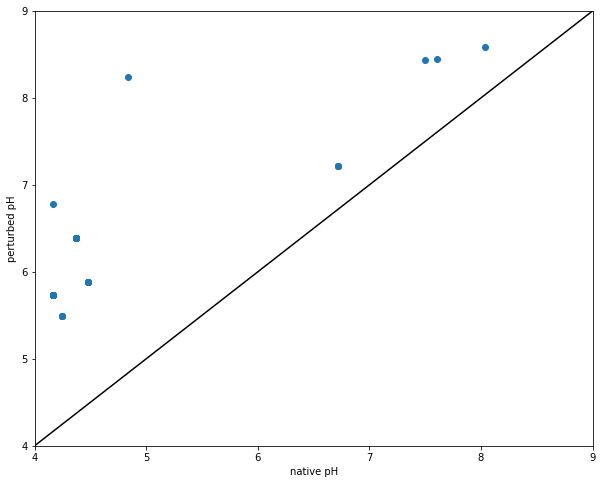

In [33]:
data = pd.read_csv('out/native_versus_perturbed_enchriment.tsv', sep='\t', header=None)
data = data.values
filtered_data = []
for pair in data:
    if pair[1] != 0:
        filtered_data.append(pair)
filtered_data = [data.tolist() for data in filtered_data]

x = [pair[0] for pair in filtered_data]
y = [pair[1] for pair in filtered_data]

plt.figure(figsize = (10,8))
plt.scatter(x,y)
plt.xlim(4,9)
plt.ylim(4,9)

x1 = np.linspace(4,9,10)
y1 = x1
plt.plot(x1,y1, color = 'black')

plt.xlabel('native pH')
plt.ylabel('perturbed pH')


Text(0.5, 1.0, 'Blue = Present, White = Absent')

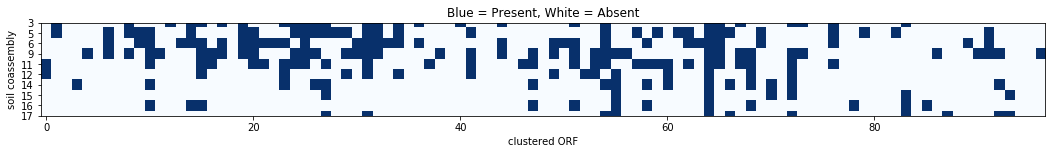

In [45]:
data = pd.read_csv('out/track_clusters.tsv', sep='\t', header=None)
data = data.values
data = data.T

plt.figure(figsize=(18,14))
plt.imshow(data, cmap = 'Blues')
plt.xlabel('clustered ORF')
plt.ylabel('soil coassembly')

labels = [3, 5, 6, 9, 11, 12, 14, 15, 16, 17]
plt.yticks(ticks=range(len(labels)), labels=labels)

plt.title('Blue = Present, White = Absent')

## Testing functions

In [ ]:
for soil in soils:
    print(soil, native_pH(soil))

In [ ]:
for soil in soils:
    print(soil, native_pH(soil))

In [ ]:
print(find_orfs(get_filepath('T0', 'annotation'), 'K00370'))

In [ ]:
print(find_orfs_from_cluster('Soil17.scaffold_502405353_c1_1'))

In [ ]:
print(find_cluster_from_orf('T0.scaffold_334770953_c1_1'))

In [ ]:
#Soil5, 6, 9, 11, 12, 14, 15, 16, 17
prefixes = ['T0', 'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

for prefix in prefixes:
    ORFS = find_clustered_orfs(get_filepath(prefix, 'annotation'), 'K00370')
    print(prefix, '\n')
    print(len(ORFS))


Below, I'm looking to find out which cluster IDs are present in all soils. This is also completed in track_clusters.py

In [ ]:
##want to find out which clusters are found everywhere 

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]

cluster_tracker = np.zeros((len(cluster_IDs), len(soils)))


for soil in soils:
    yes = 0
    no = 0
    col_idx = soils.index(soil)
    ORFS = find_orfs(get_filepath(soil, 'annotation'), 'K00370')
    for orf in ORFS:
        cluster = find_cluster_from_orf(orf)
        if cluster in cluster_IDs:
            row_idx = cluster_IDs.index(cluster)
            yes += 1
            print('yes')
            cluster_tracker[row_idx, col_idx] = 1
        else:
            no += 1
            print('no')
    print(soil, 'yes = ', yes, 'no = ', no)
    
print(cluster_tracker)
        